### Week 11: Dimensionality reduction

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>


Citations: <br>
   - Chapter 5: Python Machine Learning 3rd Edition by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019
   - https://www.mathsisfun.com/algebra/eigenvalue.html
   - https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=Processing%20Procedure-,Preparing%20Analysis%20Data,0.3%2C%20PCA%20will%20not%20help.
   - https://charlesreid1.github.io/circe/Digit%20Classification%20-%20PCA.html

### Objectives: 
 - Principal component analysis (PCA): unsupervised data, suitable for linearly separable data.
 - Linear disciminant analysis (LDA): supervised data, suitable for linearly separable data.
 - Kernel principal component (KPCA): unsupervised data, suitable for nonlinearly separable data.
 - Breakout room exercise.

### Dimensionality reduction - two ways:

   - feature selection: select a subset of the original features.
   - feature extraction: transform (project) the data into a new feature subspace, with the goal of mantaining most of the relevant information.

``Feature selection:``

   - can use L1 regularization; or
   - can use greedy search algorithms (e.g., sequential backward selection (SBS)), random forests.

``Feature extraction:``

   - PCA, LDA, KPCA, and many others...

### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

### Step 2: Define functions

### Step 3: Read data

Today we will return to our old friend, the wine dataset :)

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
              'alcalinity_of_ash', 'magnesium', 'total_pphenols',
              'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
              'proline']

# recode class labels (from 0 to 2)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping
df['class_label'] = df.class_label.map(class_mapping)

print('Shape of df wine:', df.shape)
print('Class labels:', df['class_label'].unique())
print()
df.head()

Shape of df wine: (178, 14)
Class labels: [0 1 2]



,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,0,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,0,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,0,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


---
### Principal Component Analysis (PCA):

   - start with $d$-dimensional data with the aim to transform it into a $k$-dimensional subspace ($k<<d$).
   - to transform the data, find the principal components (i.e., the directions of maximum variance).
   - the first principal component will have the largest possible variance.
   - the consequent principal components will have largest variance given that they are orthogonal to the other principal components.
   - **very important**: make sure features are on the same scale as PCA directions are very sensitive to data scaling!

``Question:`` What does orthogonal mean?

X1 and X2 are the orginial features, and PC1 and PC2 are the principal components.


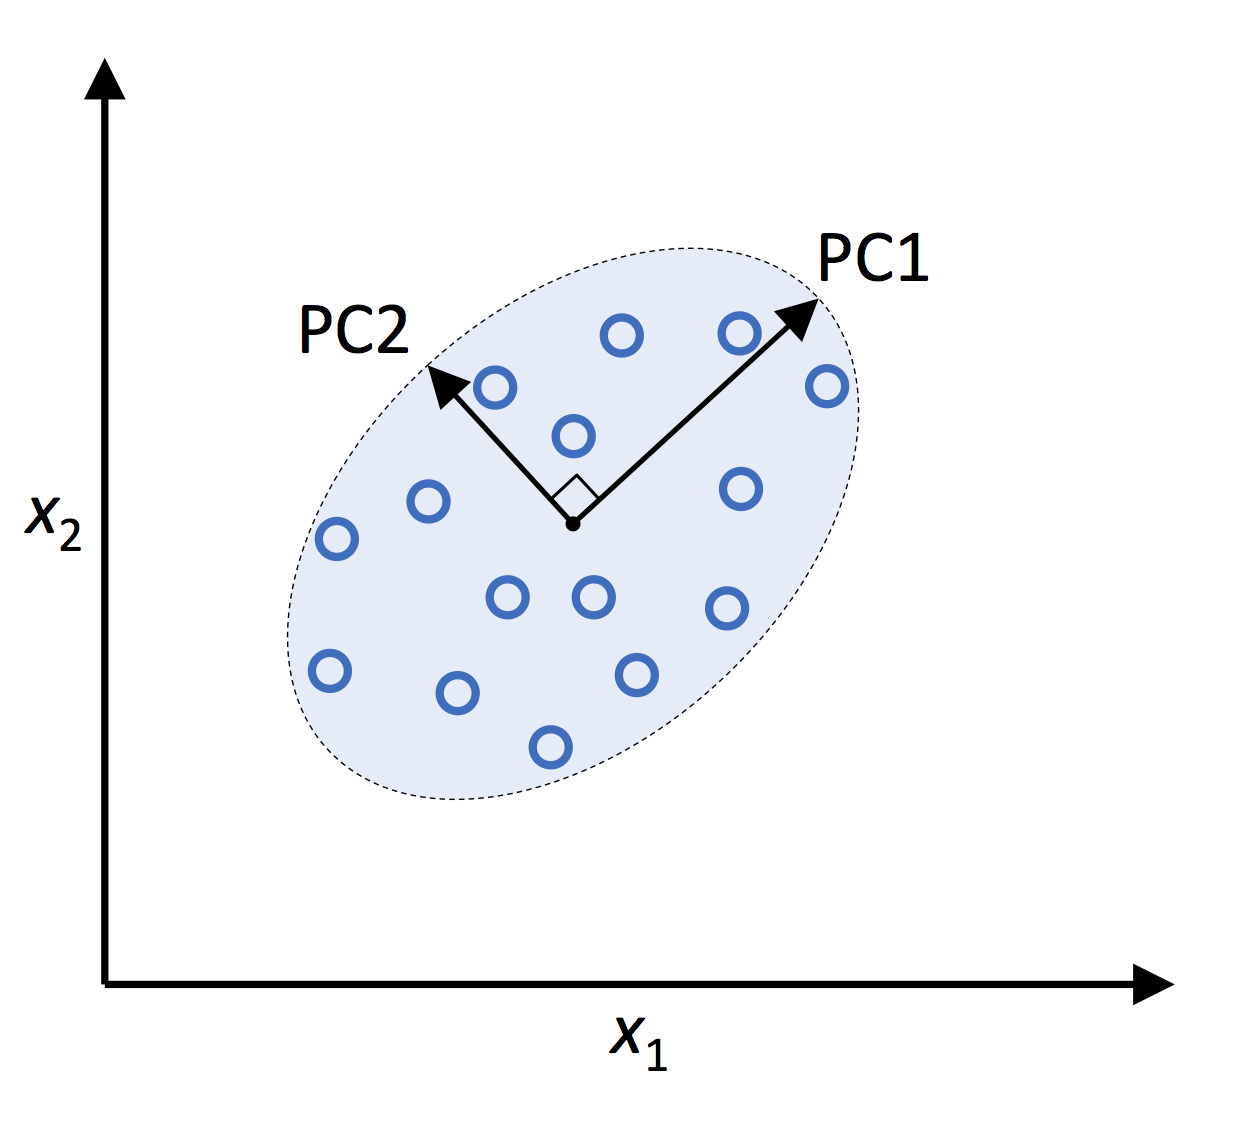

In [3]:
print("X1 and X2 are the orginial features, and PC1 and PC2 are the principal components.")
Image(filename='PCA.png', width=300)

Let's write the idea behind CPA using math notation:

- assume we have a feature input dataset $\mathbf{X} = {x_1, x_2, ..., x_d}, x\in {\Bbb R}^d$.
- assume we have a transformation matrix $\mathbf{W} \in {\Bbb R}^{d \times k}$.
- then PCA is multiplying the original input dataset by the transformation matrix such that:

$ \; \; \; \; \; \; \mathbf{XW = z}$, where $\mathbf{z} = {z_1, z_2, ..., z_k}, \in {\Bbb R}^k$ is the output vector

My goal today is to show you how to implement PCA from scratch and then test our implementation using the built-in scikit-learn PCA module.

``The PCA algorithm`` (we want to reduce a input dataset of dimension $d$ to dimension $k$, where $k<<d$:

   - Part 1: standardize the features in the original input dataset.
   - Part 2: construct the covariance matrix.
   - Part 3: decompose the covariance matrix into eigenvectors and eigenvalues.
   - Part 4: rank the eigenvalues by sorting them in decreasing order.
   - Part 5: select $k$ eigenvectors (based on the $k$ largest eigenvalues). 
   - Part 6: construct the projection matrix, $\mathbf{W}$, using the top $k$ eigenvectors.
   - Part 7: transform the original input dataset, $\mathbf{X}$, using the projection matrix, $\mathbf{W}$, to obtain the new $k$-dimensional feature subspace.

### Part 1: Standaridize the features in the original dataset

In [4]:
# create X and y numpy arrays
X, y = df.iloc[:,1:].values, df.iloc[:,0].values

# create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   stratify=y, random_state=0)

# standardize the features (learn mean and variance from train data. Use these values to standardize both the train and test data!)
sc = StandardScaler()
sc.fit(X_train)
print("Mean: ", sc.mean_, '\nVariance: ', sc.var_)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Mean:  [1.30335484e+01 2.35379032e+00 2.38491935e+00 1.98016129e+01
 9.90887097e+01 2.32483871e+00 2.06411290e+00 3.68064516e-01
 1.64088710e+00 5.08959677e+00 9.54193548e-01 2.61935484e+00
 7.54822581e+02] 
Variance:  [6.77935796e-01 1.36704612e+00 7.18653161e-02 1.10691909e+01
 1.97564711e+02 3.78049168e-01 1.03926937e+00 1.46849636e-02
 3.48232278e-01 5.57011024e+00 4.87437045e-02 4.80177003e-01
 1.05880114e+05]


In [5]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


We have 13 features in the wine dataset, so we have 13 mean and variance values we use to standardize each feature.

### Part 2: Construct the covariance matrix

In [6]:
cov_matrix = np.cov(X_train_std.T)
pd.DataFrame(cov_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.008130,0.067096,0.174054,-0.354391,0.263747,0.290795,0.218358,-0.081120,0.104367,0.542828,0.058935,-0.017970,0.641529
1,0.067096,1.008130,0.083265,0.263568,-0.113492,-0.337356,-0.410353,0.336539,-0.216027,0.175042,-0.551593,-0.405617,-0.240900
2,0.174054,0.083265,1.008130,0.464204,0.290928,0.180204,0.155375,0.159188,-0.007038,0.205491,0.006654,0.020390,0.223495
3,-0.354391,0.263568,0.464204,1.008130,-0.074064,-0.280607,-0.313919,0.315814,-0.246211,-0.088727,-0.225956,-0.167999,-0.463934
4,0.263747,-0.113492,0.290928,-0.074064,1.008130,0.256676,0.210258,-0.260034,0.196017,0.206065,0.133598,0.066333,0.418110
5,0.290795,-0.337356,0.180204,-0.280607,0.256676,1.008130,0.871237,-0.449798,0.623341,-0.056899,0.506641,0.719787,0.529869
6,0.218358,-0.410353,0.155375,-0.313919,0.210258,0.871237,1.008130,-0.548241,0.648009,-0.158649,0.604171,0.793196,0.528361
7,-0.081120,0.336539,0.159188,0.315814,-0.260034,-0.449798,-0.548241,1.008130,-0.399893,0.198106,-0.366293,-0.576230,-0.340997
8,0.104367,-0.216027,-0.007038,-0.246211,0.196017,0.623341,0.648009,-0.399893,1.008130,-0.003301,0.320195,0.506155,0.329761
9,0.542828,0.175042,0.205491,-0.088727,0.206065,-0.056899,-0.158649,0.198106,-0.003301,1.008130,-0.458341,-0.466675,0.321562


``Question:`` Why are the diagonal elements equal to 1?

### Part 3: decompose the covariance matrix into eigenvectors and eigenvalues
Before we dig into the coding part, let's remember a lesson from our introductory linear algebra class:

 - the eigenvectors of the covariance matrix represent the directions of maximum variance (the principal components)
 - the eigenvalues of the covariance matrix represent the magnitude of the principal components.

We should obtain 13 eigenvectors and 13 eigenvalues from the wine dataset!

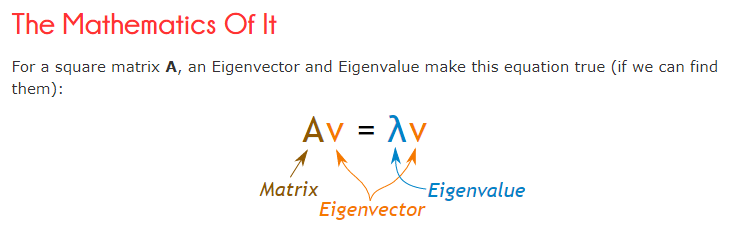

In [7]:
Image(filename="eigendecomposition.png", width=700)

A is our cov_matrix! Check here for the simple math behind this equation: https://www.mathsisfun.com/algebra/eigenvalue.html

In [8]:
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

In [9]:
print('Eigenvalues: ')
pd.DataFrame(eigen_values)

Eigenvalues: 


,0
0,0.107546
1,0.153628
2,0.180861
3,0.213572
4,0.313137
5,0.346504
6,0.518285
7,0.662063
8,0.841662
9,0.961204


In [10]:
print('Eigenvectors :')
pd.DataFrame(eigen_vectors)

Eigenvectors :


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.094487,-0.127835,0.262834,0.374639,0.398377,-0.368176,0.079053,-0.299097,-0.290625,-0.003296,0.137749,0.503035,-0.137242
1,0.026365,0.080640,-0.266769,-0.137406,-0.110458,-0.012578,-0.274002,-0.627036,0.089538,0.562647,-0.096150,0.164871,0.247243
2,0.142748,0.016792,-0.115543,0.461583,-0.382497,0.177578,0.132328,-0.000389,-0.160835,-0.108977,-0.677776,0.244565,-0.025452
3,-0.130486,-0.110846,0.199483,-0.418954,0.243374,-0.440592,0.223999,0.040584,0.051587,0.033819,-0.625041,-0.113529,0.206945
4,-0.067608,0.079388,0.028902,0.010047,0.258982,0.116618,-0.405269,-0.065777,0.676487,-0.367511,-0.196135,0.289745,-0.154366
5,0.459918,-0.491459,-0.066387,-0.221254,0.342313,0.350192,-0.034742,0.058978,-0.118511,0.240245,-0.140311,0.050801,-0.393770
6,-0.814584,-0.050307,-0.213349,-0.041751,0.036123,0.218718,0.041784,0.030110,-0.107100,0.187053,-0.117054,-0.022873,-0.417351
7,-0.095748,0.175328,0.186391,-0.088757,0.171437,0.197129,-0.631146,0.271728,-0.507582,-0.022926,-0.131218,0.090489,0.305729
8,0.067247,-0.003676,0.168083,0.199922,-0.244370,-0.433056,-0.323123,0.439998,0.201635,0.496262,-0.030431,0.008352,-0.306683
9,0.087334,0.359757,-0.466369,-0.221669,0.155515,-0.066841,0.269083,0.411743,0.005736,0.106483,0.079930,0.549776,0.075541


### Part 4: rank the eigenvalues by sorting them in decreasing order.

Let's pause for a second to understand why this step is important. 

Out main objective is to reduce the dimensionality of the original wine dataset (i.e., from 13 features to $k$ features). To do so, we need only select a subset of the eigenvectors (principal components) that contain most of the information (variance).

``Question:`` what do eigenvalues define?

We are interested in the top $k$ eigenvectors as defined by their coresponding eigenvalue.

Let's plot the **explained variance ratio** of the eigenvalues:

$ = \frac{\lambda_j}{\sum_{j=1}^d \lambda_j}$, where d = 13 in the wine dataset.
So the explained variance ratio is the fraction of an eigenvalue $j$ and the total sum of eigenvalues.

In [11]:
# compute the explained variance ratio
sum_eigen_values = sum(eigen_values)
print('Sum eigenvalues: ', sum_eigen_values)

expl_var_ratio = [i/sum_eigen_values for i in sorted(eigen_values, reverse=True)]
print('\nExplained variance ratio:')
pd.DataFrame(expl_var_ratio)

Sum eigenvalues:  13.105691056910569

Explained variance ratio:


,0
0,0.369515
1,0.184349
2,0.118152
3,0.073343
4,0.064221
5,0.050517
6,0.039547
7,0.026439
8,0.023893
9,0.016296


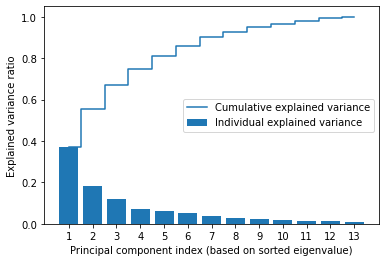

In [12]:
# visualize the explained variance ratio and the cumulative explained variance ratio
x_axis = range(1,len(eigen_values)+1)
y_axis = expl_var_ratio

# plot individual ratio
plt.bar(x_axis, y_axis, label='Individual explained variance')
# plot cumulative ratio
plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

# legend, labels
plt.legend()
plt.xticks(x_axis)
plt.ylabel('Explained variance ratio');
plt.xlabel('Principal component index (based on sorted eigenvalue)');

``Question:`` what can we conclude from here? How much of the total variance does the first principal component explain? What about the two principal components combined?

### Part 5: select $k=2$ eigenvectors (based on the $k=2$ largest eigenvalues)

k=2 is the dimensionality of the new feature data we want to create.

In [13]:
# create eigen pairs of vectors and values
eigen_pairs = [(eigen_values[i], eigen_vectors[:,i]) for i in range(len(eigen_vectors))]

# transform to df
eigen_pairs = pd.DataFrame(eigen_pairs)
eigen_pairs.rename(columns={0: 'eigen_value', 1: 'eigen_vector'}, inplace=True)
eigen_pairs.head()

,eigen_value,eigen_vector
0,0.107546,"[-0.0944869777062284, 0.02636524058001842, 0.1..."
1,0.153628,"[-0.1278345148573658, 0.0806401577714189, 0.01..."
2,0.180861,"[0.2628342626338234, -0.26676921080929156, -0...."
3,0.213572,"[0.3746388768518964, -0.1374055970978627, 0.46..."
4,0.313137,"[0.39837701653611357, -0.1104582302331723, -0...."


In [14]:
# select the top 2 eigenvectors based on the eigenvalue
top2_eigen_vectors = eigen_pairs.nlargest(2, 'eigen_value')['eigen_vector'].values.tolist()
top2_eigen_vectors

[array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
        -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
        -0.32613263, -0.36861022, -0.29669651]),
 array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
         0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
        -0.20716433, -0.24902536,  0.38022942])]

#### Part 6: construct the projection matrix, $\mathbf{W}$, using the top $k=2$ eigenvectors.

In [15]:
w = np.hstack((top2_eigen_vectors[0][:, np.newaxis],
               top2_eigen_vectors[1][:, np.newaxis],
               #top2_eigen_vectors[2][:, np.newaxis]
              ))
print('Matrix W:\n', w)
print('\nSize of Matrix W: ', w.shape)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]

Size of Matrix W:  (13, 2)


### Part 7: transform the original input dataset, $\mathbf{X}$, using the projection matrix, $\mathbf{W}$,

to obtain the new $k$-dimensional feature subspace: $\mathbf{XW = z}$

In [16]:
# training data
X_train_pca = X_train_std.dot(w)
pd.DataFrame(X_train_pca).head()

,0,1
0,2.382990,0.454585
1,-1.965782,1.653769
2,-2.539076,1.029091
3,-1.430108,0.602401
4,3.141472,0.662150


In [17]:
# test data
X_test_pca = X_test_std.dot(w)
pd.DataFrame(X_test_pca).head()

,0,1
0,-2.235751,1.861806
1,0.537318,-1.661339
2,-2.362042,1.147674
3,-2.097719,-0.155720
4,-2.171636,-1.443650


Let's visualize the new PCA 2-D features in the train wine dataset,

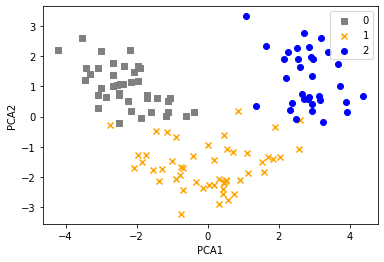

In [18]:
colors = ['grey', 'orange', 'blue']
markers = ['s', 'x', 'o']

# plot
for class_value, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==class_value, 0],
                X_train_pca[y_train==class_value, 1],
                color = color, label = class_value, marker=marker)
    
# legend, axes
plt.legend(loc='best')
plt.xlabel('PCA1')
plt.ylabel('PCA2');

``Questions:``
 - What can we say about the plot (compare the spread of PCA1 vs. PCA2). Is this consistent with the idea of PCA?
 - Is a linear classifier able to separate the 3 classes (cultivars) well?
 - Did we use any class label information to project the original 13-D dataset into a 2-D space using PCA?
 - Can we use PCA to reduce overfitting?
 - What is the meaning of the newly created features (before we had 'alcohol', 'ash', etc; so what's the meaning now??).

Let's now see PCA implemented in scikit-learn. The idea is to:
 - fit the data using the original X_train_std data
 - transform both X_train_std and X_test_std data using the same PCA parameters

In [19]:
# create an instance of the PCA class
pca = PCA(n_components=2)

# fit the data using the original X_train_std data; tranform X_train_std data
X_train_pca_skl = pca.fit_transform(X_train_std)

# transform the X_test_std data
X_test_pca_skl = pca.transform(X_test_std)

Finally, let's compare the outputs between our implementation and sklearn for the training data.

In [20]:
print('X_train_pca: our implementation\n')
pd.DataFrame(X_train_pca).head()

X_train_pca: our implementation



,0,1
0,2.382990,0.454585
1,-1.965782,1.653769
2,-2.539076,1.029091
3,-1.430108,0.602401
4,3.141472,0.662150


In [21]:
print('X_train_pca: sklearn implementation\n')
pd.DataFrame(X_train_pca_skl).head()

X_train_pca: sklearn implementation



,0,1
0,2.382990,0.454585
1,-1.965782,1.653769
2,-2.539076,1.029091
3,-1.430108,0.602401
4,3.141472,0.662150


Let's fit a Perceptron model with X_train_std and x_train_pca and see if X_train_pca does better.

In [22]:
from sklearn.linear_model import Perceptron
lm = Perceptron()
lm.fit(X_train_std, y_train)
print("perceptron score using standardized data:", lm.score(X_test_std, y_test))

perceptron score using standardized data: 0.9814814814814815


In [23]:
lm = Perceptron()
lm.fit(X_train_pca, y_train)
print("perceptron score using pca data:", lm.score(X_test_pca, y_test))

perceptron score using pca data: 0.9259259259259259


``Question:`` What can we conclude from here?

Let's look at the correlation matrix between features.

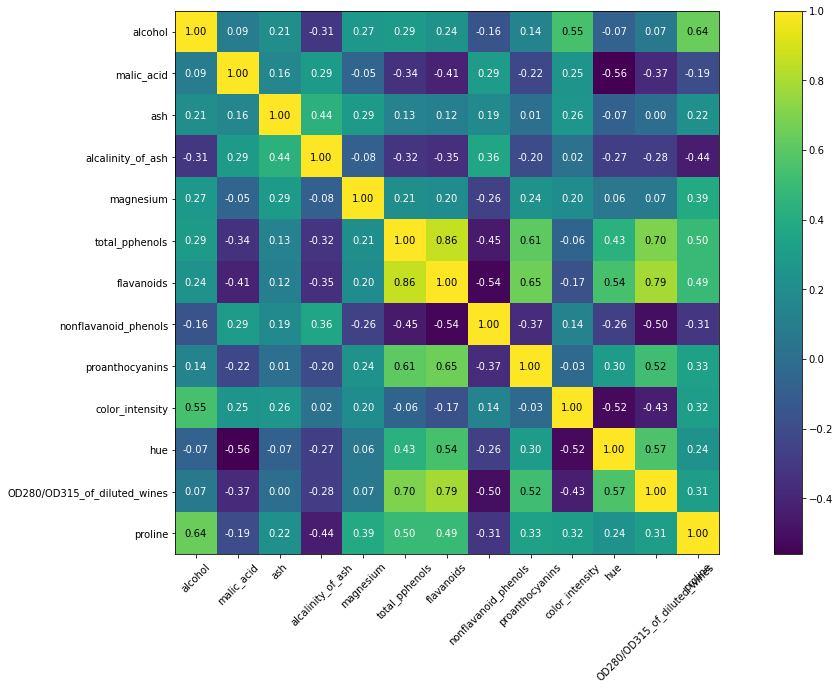

In [24]:
from mlxtend.plotting import heatmap
features = ['alcohol', 'malic_acid', 'ash',
              'alcalinity_of_ash', 'magnesium', 'total_pphenols',
              'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
              'proline']
cm = df[features].corr().values
hm = heatmap(cm, row_names=features, column_names=features, figsize=(20, 10))

In [25]:
# look at the mean correlation by row (symmetric matrix, you should get the same results if you do by columns)
for i in range(len(cm)):
    print(cm[i].mean())

0.22798994955883004
-0.004200481399901594
0.22748007744005783
-0.010936742512822424
0.19419317578352435
0.27537323271180336
0.2628570294683585
-0.0663855101369639
0.2295196388940607
0.11728323302294198
0.1048950975243535
0.18839496691904942
0.2695749083094645


One lesson: PCA should be used mainly for variables which are strongly correlated. If the relationship is weak between variables, PCA does not work well to reduce data. Refer to the correlation matrix to determine. In general, if most of the correlation coefficients are smaller than 0.3, PCA will not help. (Source: https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=Processing%20Procedure-,Preparing%20Analysis%20Data,0.3%2C%20PCA%20will%20not%20help).

Another lesson: it also depends on (1) the classification model you use, (2) the value of d (dimension of the original features), (3) the value of k (dimension of new (reduced) data - you may throw away variables that actually contribute to the variance). So whenever you fit a model, I recommend looking at the results w/ and w/o PCA. But sometimes the data is soo big (course of dimensionality) that you may just be better of using PCA.

``Exercise:`` try using only features = ['total_pphenols','flavanoids', 'OD280/OD315_of_diluted_wines']. If you look at the correlation matrix we can see they are highly correlated.

---
### Linear Discriminant Analysis (LDA):

   - PCA finds the orthogonal elements of maximum variance in a dataset.
   - LDA finds the feature space that optimizes class separability.
   - Both PCA and LDA use linear transformation techniques to reduced the dimensionality of the data.

I will let you explore the inner workings of LDA by yourself!

---
### Kernel Principal Analysis (KCPA):
 - Some of the classification algorithm you have learned in this class require perfectly separable data to make predictions accurately.
 - If data is not linearly separable then PCA and LDA may not be the best choice.
 - KPCA is just a kernelized version of PCA, which relates to the concept of kernel SVM.
 - So we will learn how to transform data that is not linearly separable onto a new, lower-dimensional subspace, suitable for linear classifiers.

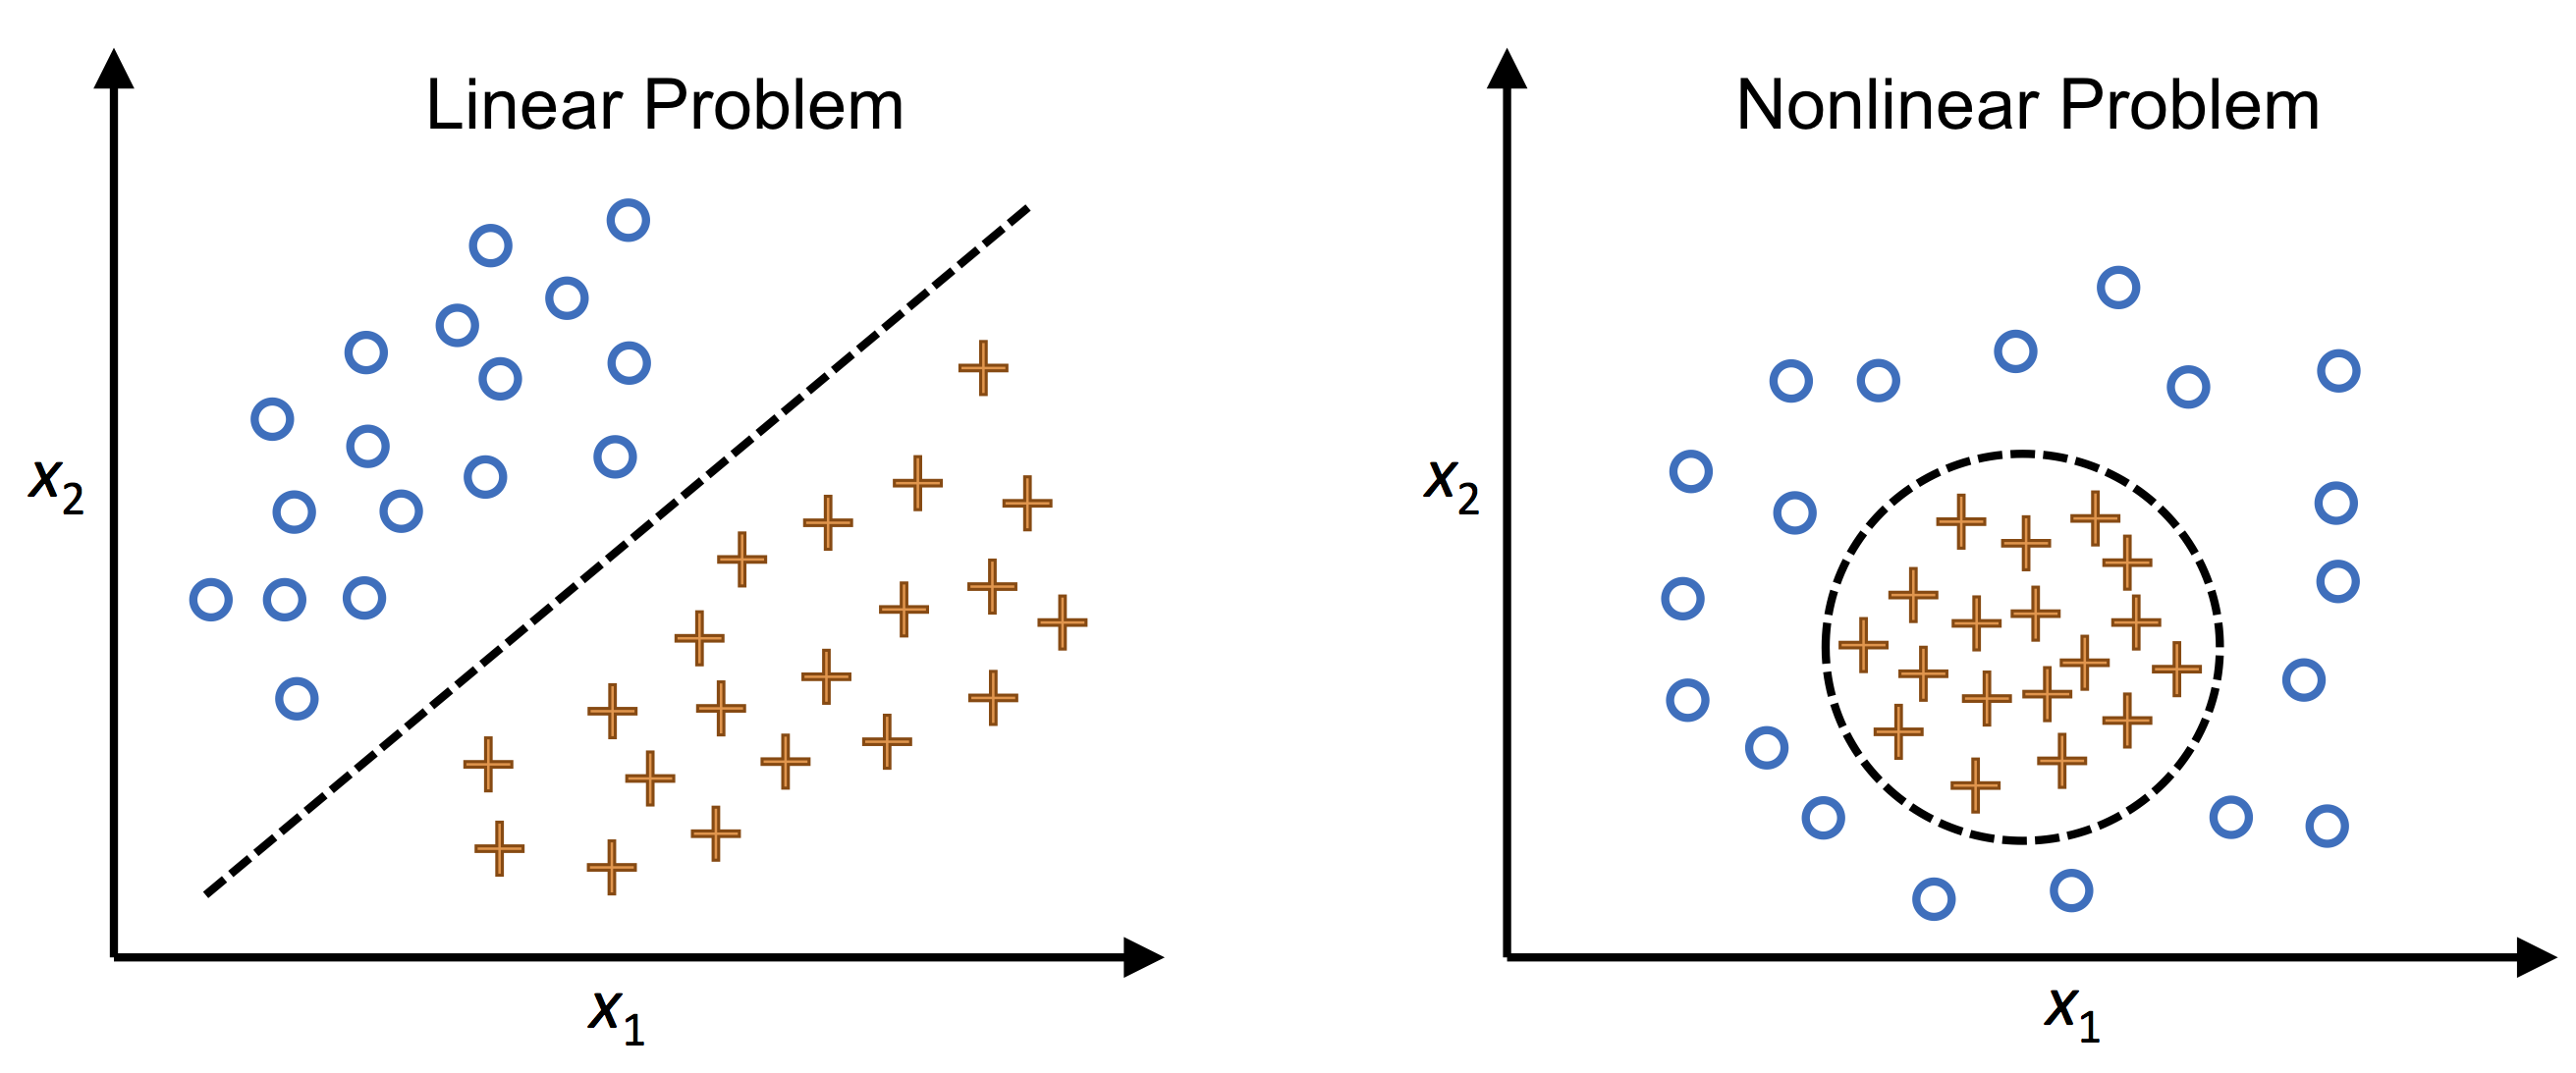

In [26]:
Image(filename="linear_nonlinear.png", width=400)

``Question 1:`` How did we deal with nonlinear data in kernel SVM?

``Question 2:`` So how do you think we deal with nonlinear data in KPCA?

Version 1:

   - Step 1: transform the data into a higher dimensional space.
   - Step 2: use standard PCA to project the data back onto a lower-dimensional space.
        
Version 2:

   - use the kernel trick, which just kernalizes the covariance matrix.
   - kernels: Radial Basis Function (RBF) or Gauss kernel; polynomial kernel; hyperbolic tangent (sigmoid) kernel.

Let's now use the KernelPCA method available in the sklearn.decomposition module to see if we can improve the performance of our perceptron model.

In [28]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.2) # try 0.2
X_train_kpca = kpca.fit_transform(X_train_std)
X_test_kpca = kpca.transform(X_test_std)

lm = Perceptron()
lm.fit(X_train_kpca, y_train)
print("perceptron model score using kpca data:", lm.score(X_test_kpca, y_test))

perceptron model score using kpca data: 0.9814814814814815


``Question:`` What can we conclude from here? Why did the KernelPCA performed actually even worse?

Note: the gamma hyperparameter needs to be tuned!

Breakout rooms exercise: 
 - Apply PCA and KPCA to the MNIST Digit Classification data. 
 - Fit a single-layer NN (logistic regression) and report accuracy (compare model with dimensionality reduction (PCA, KPCA) with model w/o dimensionality reduction.